In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plotter(title, x_list, y_list):
    plt.figure(figsize=(8, 6))

    plt.title(title, size=15, color="red")
    plt.plot(x_list, y_list)
    plt.grid()

    plt.show()

### 活性化関数

In [3]:
# ステップ関数
def step(x):
    if x <= 0:
        return 0
    else:
        return 1

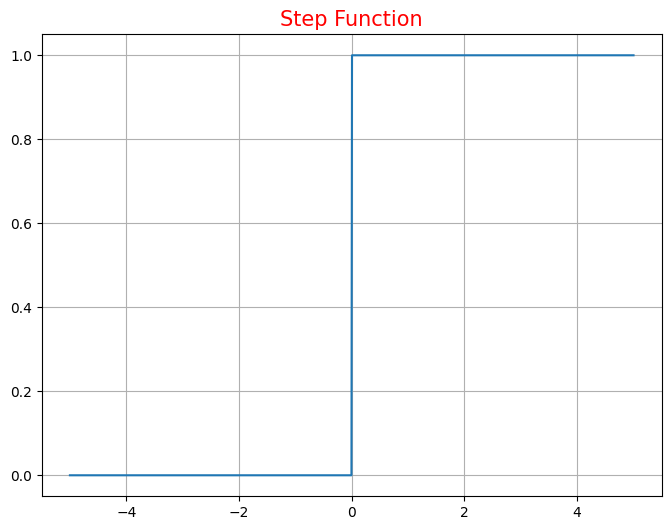

In [4]:
x_list = np.linspace(-5, 5, 1000)
y_list = [step(x) for x in x_list]

plotter("Step Function", x_list, y_list)

In [5]:
# シグモイド関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

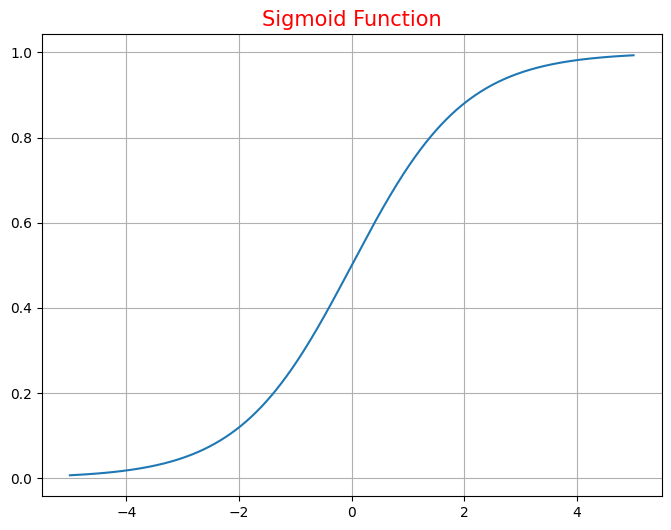

In [6]:
x_list = np.linspace(-5, 5, 1000)
y_list = [sigmoid(x) for x in x_list]

plotter("Sigmoid Function", x_list, y_list)

In [7]:
# ReLU関数
def relu(x):
    if x > 0:
        return x
    else:
        return 0

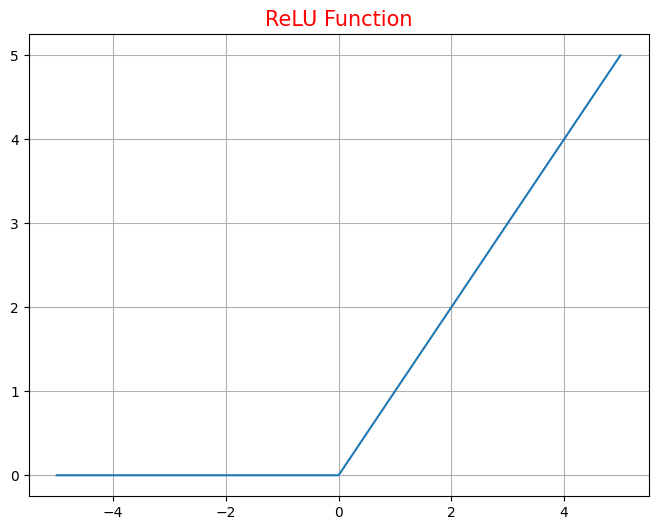

In [8]:
x_list = np.linspace(-5, 5, 1000)
y_list = [relu(x) for x in x_list]

plotter("ReLU Function", x_list, y_list)

### チュートリアル

#### データのロード

In [9]:
from sklearn.datasets import load_diabetes

In [10]:
data = load_diabetes()
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

#### 前処理

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# 説明変数をX, 目的変数をyとする
X = data.data
y = data.target

In [13]:
type(y)

numpy.ndarray

In [14]:
# データを学習用とテスト用に分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=8192)

# テストデータを開発用と評価用に分ける
X_valid, X_eval, y_valid, y_eval = train_test_split(X_test, y_test, test_size=0.50, random_state=8192)

#### PyTorchを用いて学習できるようにデータの処理

In [15]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

In [16]:
def list_to_torch(X, y):
    # ndarray型に変換
    X = np.array(X)
    y = np.array(y)

    # Tensor型に変換
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()

    return X, y

In [17]:
X_train, y_train = list_to_torch(X_train, y_train)
X_valid, y_valid = list_to_torch(X_valid, y_valid)
X_eval, y_eval = list_to_torch(X_eval, y_eval)

In [18]:
# 学習のためさらに整形
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

In [19]:
# DataLoader型に変換
batch_size = 1

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

#### ニューラルネットワークモデルの構築

In [20]:
from torch import nn

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Tensor型のデータの一次元化
        self.flatten = nn.Flatten()

        # nn.Sequential：中間層のレイヤーを敷き詰める
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10, 32), # 1層目：10次元から32次元への写像
            nn.ReLU(), # 活性化関数にはReLUを用いる
            nn.Linear(32, 8), # 2層目
            nn.ReLU(),
            nn.Linear(8, 1) # 3層目：1次元へ
        )

    # モデルの流れを作る
    def forward(self, x):
        x = self.flatten(x)
        outputs = self.linear_relu_stack(x)
        return outputs

In [22]:
# 原則GPU(cuda)で学習し、ローカルのCPUでしか扱えなければそのまま
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [23]:
# インスタンスの作成
model = NeuralNetwork().to(device)

#### 学習用の最適化器と損失関数の設定

・最適化器・・・評価したい関数のパラメータの値を変更することで、より良い値に最小化(or最大化)するための一連の処理の手法.

In [24]:
# SGD・・・勾配ベースの最適化を行う
from torch.optim import SGD

In [25]:
# 引数lrは学習率:前に学習したものよりも優先度を下げて学習することで、過学習を防ぐ
optimizer = SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

#### モデルの学習

In [26]:
from tqdm import tqdm

In [37]:
def model_train(epochs, train_dataloader, valid_dataloader, model, optimizer, criterion, batch_size):
    dataloader_dict = {
        "Train": train_dataloader,
        "Valid": valid_dataloader
    }

    # 学習ロスのリスト
    training_data = []
    # 進行状況のプログレスバーを表示
    with tqdm(range(epochs)) as pbar_epoch:
        for epoch in pbar_epoch:
            pbar_epoch.set_description(f"epoch : {epoch + 1}")
            metas = []

            # 学習中orテスト中で処理を分岐
            for phase in ["Train", "Valid"]:
                if phase == "Train":
                    model.train()
                else:
                    model.eval()

                epoch_loss = 0.0

                for inputs, label in dataloader_dict[phase]:
                    inputs = inputs.to(device)
                    label = label.to(device)
                    optimizer.zero_grad()

                    # 学習中のみ、勾配の計算を行う
                    with torch.set_grad_enabled(phase == "Train"):
                        outputs = model(inputs)
                        loss = criterion(outputs, label) ** 0.5
                        
                        # 逆伝播を行う
                        if phase == "Train":
                            loss.backward()
                            optimizer.step()

                        epoch_loss += loss.item() * inputs.size(0)

                # エポックのロスを計算
                epoch_loss = epoch_loss / (len(dataloader_dict[phase].dataset) * batch_size)

                # エポックごとのロスを連結
                meta = {"Loss": epoch_loss}
                metas.append(meta)
            
            training_data.append(dict(zip(["Train", "Valid"], metas)))

    return model, training_data

In [38]:
# 学習
model, training_data = model_train(
    epochs=100,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch_size=batch_size
)

epoch : 100: 100%|██████████| 100/100 [00:04<00:00, 22.11it/s]


#### 学習結果の確認

In [39]:
def plot_data(training_data, mode):
    train_y = [training_data[i]["Train"][mode] for i in range(len(training_data))]
    valid_y = [training_data[i]["Valid"][mode] for i in range(len(training_data))]

    x = [i + 1 for i in range(len(train_y))]

    plt.figure(figsize=(18, 12))
    plt.title(f"{mode} comparison", size=15, color="red")
    plt.grid()

    plt.plot(x, train_y, label="Train")
    plt.plot(x, valid_y, label="Valid")
    plt.xlabel("Epoch")
    plt.ylabel(mode)

    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.)
    plt.show()

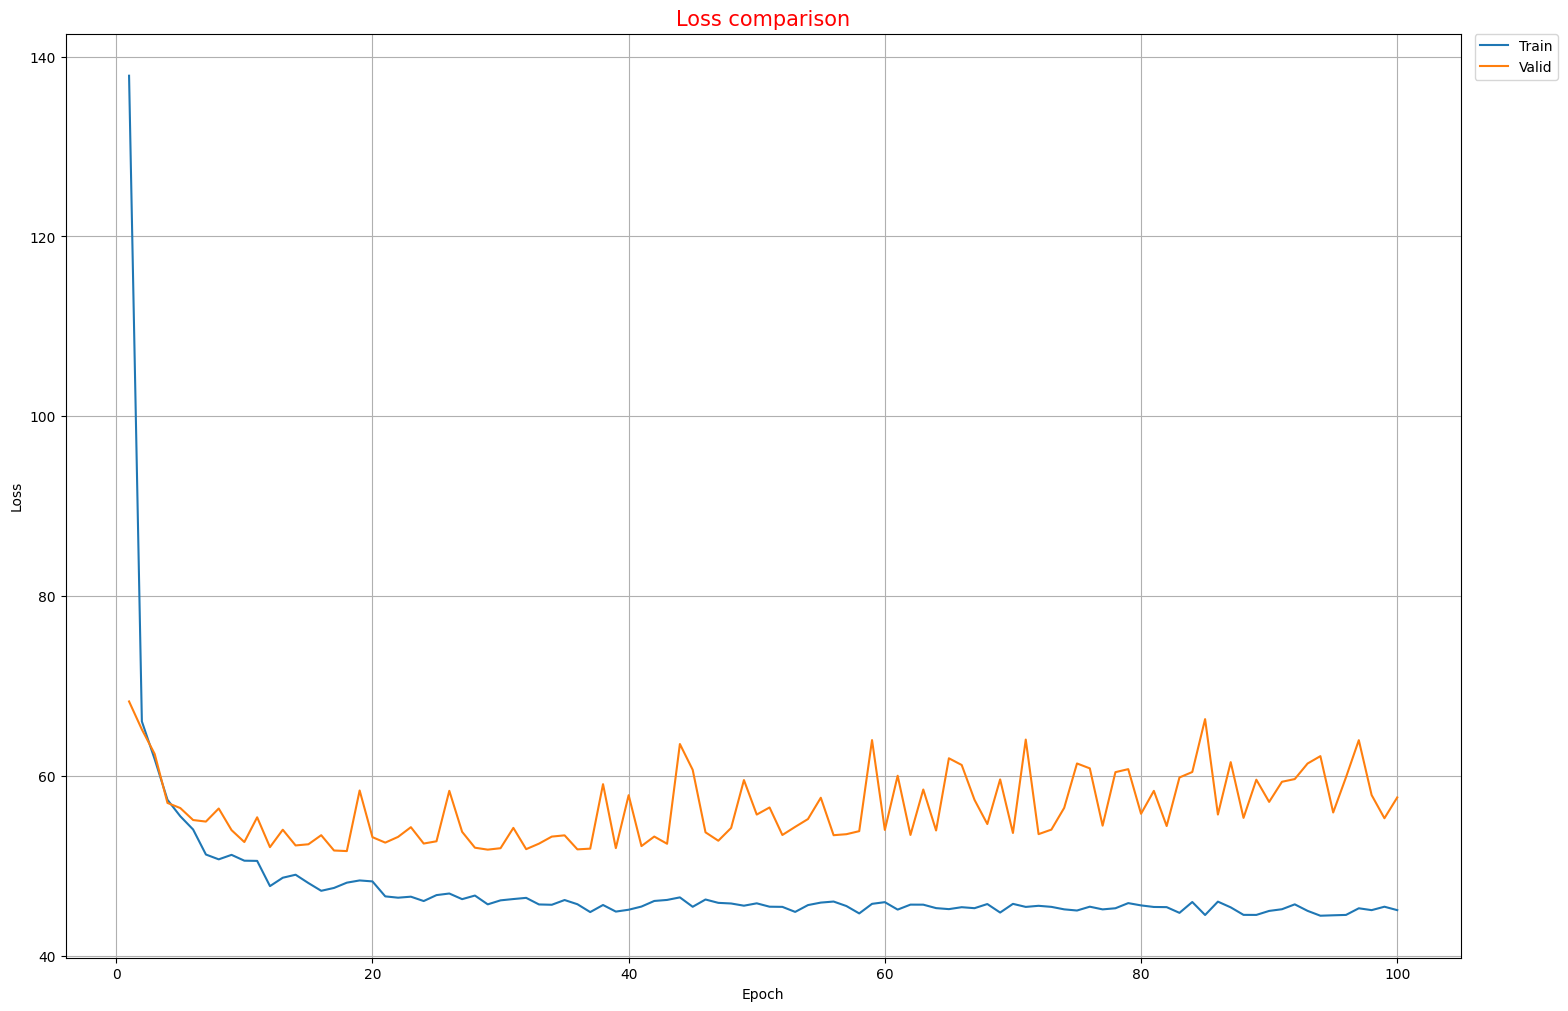

In [40]:
# ロスの推移
plot_data(training_data, "Loss")

"Eval"の方が増えていると、過学習が起きていると判断できる.

In [41]:
def torch_compare_preds(y_eval, y_pred):
    y_pred = y_pred.detach().numpy()

    plt.figure(figsize=(18, 12))
    plt.grid()

    plt.plot(y_eval, label='correct')
    plt.plot(y_pred, label='prediction')

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.show()

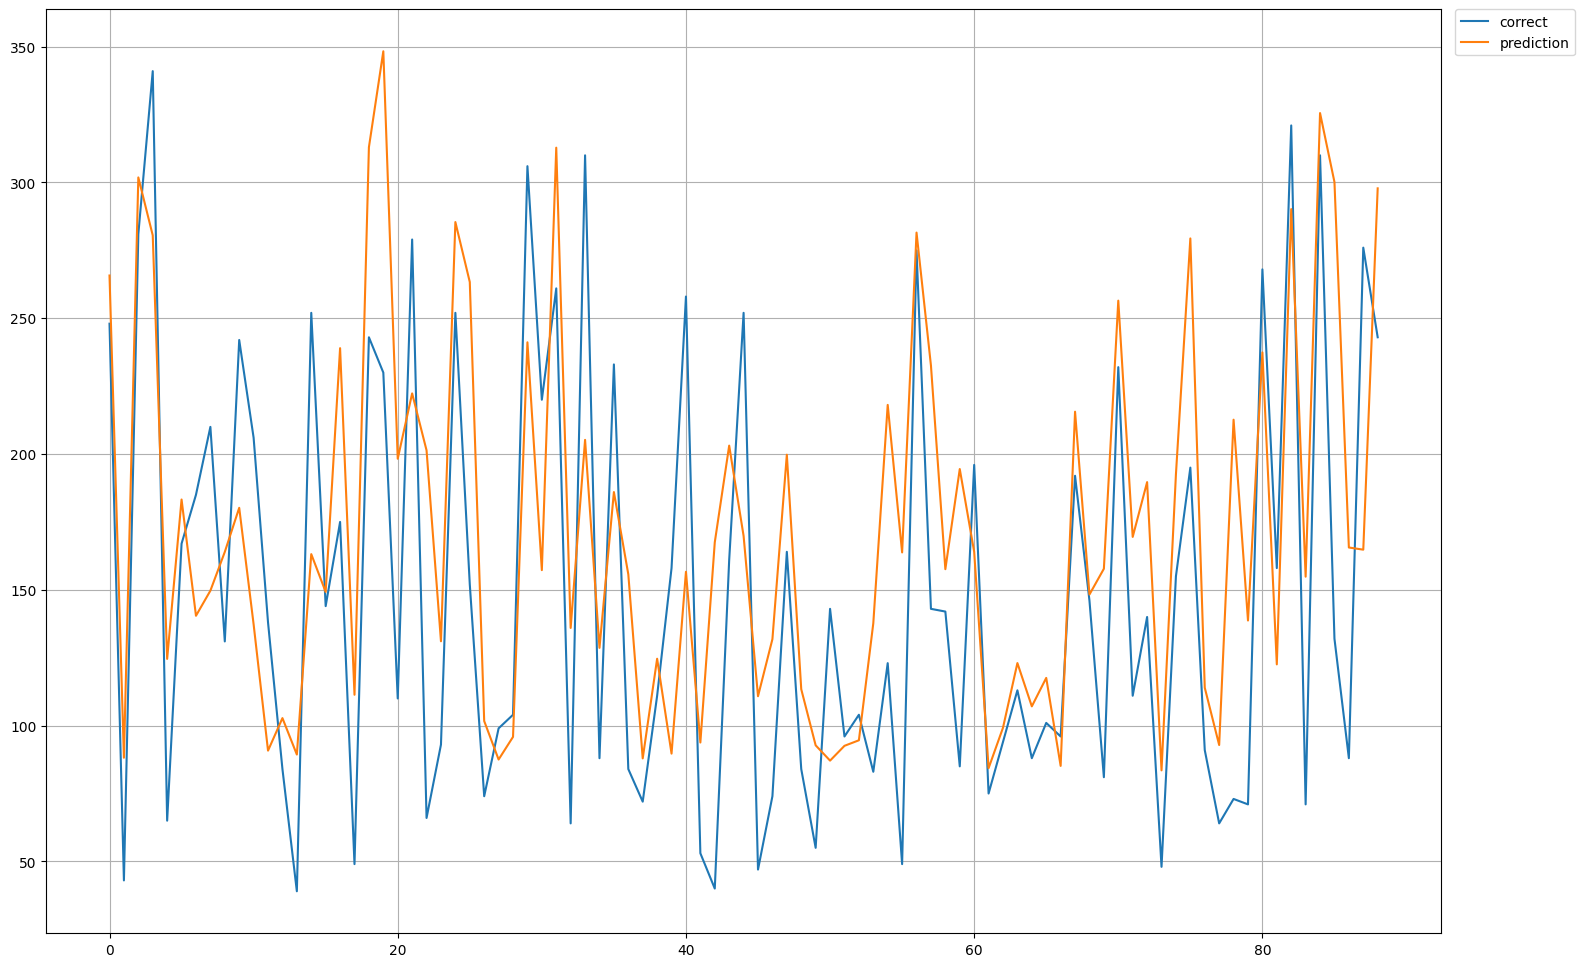

In [42]:
# y_evalとy_predの差を可視化
y_pred = model(X_eval)
torch_compare_preds(y_eval, y_pred)